In [75]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import scipy.optimize as opt
import scipy.integrate as integrate
import multiprocessing as mp
from numba import guvectorize
import matplotlib.gridspec as gridspec
import math as m

In [ ]:
### PRELIMINARY ATTEMPTS TO DEVELOP A CUT THAT EXPLOITS THE PULSE SHAPE DIFFERENCE SEEN IN THE SUPERPULSES FROM THE BETA VS ALPHA DATA ###


In [2]:
# all data taken with 4ns sampling time (250Ms/s)


file1 = "DataR_CH1@DT5725_1146_beta_test.lh5" # path to raw file
file2 = "DataR_CH1@DT5725_1146_betas_only.lh5"
in_ctrl = "DataR_CH1@DT5725_1146_no_beta_ctrl.lh5"
in_ctrl_night = "DataR_CH1@DT5725_1146_no_beta_ctrl_overnight.lh5"

in_a_foil = "DataR_CH1@DT5725_1146_alpha_foil.lh5"
in_b_foil = "DataR_CH1@DT5725_1146_beta_foil.lh5"
in_both_foil = "DataR_CH1@DT5725_1146_both_foil.lh5"

out1 = "beta_out.lh5"
out2 = "beta_only_out.lh5"
out3 = "beta_only_out_moar.lh5"

out_ctrl = "beta_ctrl.lh5"
out_ctrl_night = "beta_ctrl_overnight.lh5"

out_a_foil = "a_foil.lh5"
out_b_foil = "b_foil.lh5"
out_both_foil = "both_foil.lh5"

In [24]:
####### NECESSARY GLOBAL VARIABLES ########
bins = np.linspace(0, 6000, 1501)         #
binwidth = bins[1] - bins[0]              #
bin_centers = bins[:-1] + binwidth/2      #
adc2e = 5804/4815                         #
timeline = []
for i in range(5000):
    timeline.append(i*4)
###########################################

In [25]:
def select_n_cut(dsp_file):
    f = h5py.File(dsp_file)
    wf_blsub = f['CompassEvent']['wf_blsub']['values'][:]
    f.close()
    #cut_wfs = wf_blsub[:,900:1100]
    #max_heights = np.max(cut_wfs, axis=1)
    max_heights = np.max(wf_blsub, axis=1)
    #max_heights = max_heights[max_heights < 1700]
    #max_heights = max_heights[max_heights > 1000]
    #result = [[max_height, waveform] for max_height, waveform in zip(max_heights, cut_wfs)]
    result = np.array([[max_height, waveform] for max_height, waveform in zip(max_heights, wf_blsub)], dtype=object)
    return result


# returns list like this:    list[range][[max, wf]]

def classifier(maxes, wfs, range, wantmax = False):
    cut_data = []
    for i, max in enumerate(maxes):
        if max >= range[0] and max <= range[1]:
            if wantmax:
                cut_data.append((max,wfs[i]))
            else:
                cut_data.append(wfs[i])
    return cut_data

def slice_data_by_energy(start, stop, step, data):
    line = np.arange(start, stop+step, step)
    big_array = []
    for i in range(len(line)-1):
        temp_range = (line[i], line[i+1])
        data_slice = np.array(classifier(data[:,0], data[:,1], temp_range))
        big_array.append(data_slice)
    return np.array(big_array, dtype=object)
    

def organizer(data):
    # Sort the data by the max value (first element of each sublist)
    sorted_data = sorted(data, key=lambda x: x[0])
    return np.array(sorted_data, dtype=object)


def get_derivative_single(wf, window=(0,5000)):
    wf = wf[window[0]:window[1]]
    return np.gradient(wf)

def get_derivatives(wfs, window=(0,5000)):
    wfs = wfs[:,window[0]:window[1]]
    return np.gradient(wfs, axis=1)


In [ ]:
a_data = select_n_cut(out_a_foil)
b_data = select_n_cut(out_b_foil)
ctrl_data = select_n_cut(out_ctrl_night)

a_maxes = np.max(a_data[:,1])
b_maxes = np.max(b_data[:,1])
ctrl_maxes = np.max(ctrl_data[:,1], axis=1)

plt.hist(a_maxes, bins=bins, histtype='step')
plt.hist(b_maxes, bins=bins, histtype='step')
plt.hist(ctrl_maxes, bins=bins, histtype='step')

a_data = organizer(a_data)
b_data = organizer(b_data)
ctrl_data = organizer(ctrl_data)

a_data_slices = slice_data_by_energy(0, 900, 100, a_data)
b_data_slices = slice_data_by_energy(0, 900, 100, b_data)
ctrl_data_slices = slice_data_by_energy(0, 900, 100, ctrl_data)


In [57]:
def generate_a_over_e(wfs_sliced):
    a_over_e = []
    for i, wf_slice in enumerate(wfs_sliced):
        a_over_e.append(get_derivatives(wf_slice)/np.max(wf_slice,axis=1, keepdims=True))
    return np.array(a_over_e, dtype=object)

def average_a_over_e(a_over_e):
    averages = []
    for i, slice in enumerate(a_over_e):
        averages.append(np.mean(slice, axis=0))
    return np.array(averages, dtype=object)


In [70]:
a_i_over_e = generate_a_over_e(a_data_slices)
b_i_over_e = generate_a_over_e(b_data_slices)
c_i_over_e = generate_a_over_e(ctrl_data_slices)

a_i_over_e_avg = average_a_over_e(a_i_over_e)
b_i_over_e_avg = average_a_over_e(b_i_over_e)
c_i_over_e_avg = average_a_over_e(c_i_over_e)

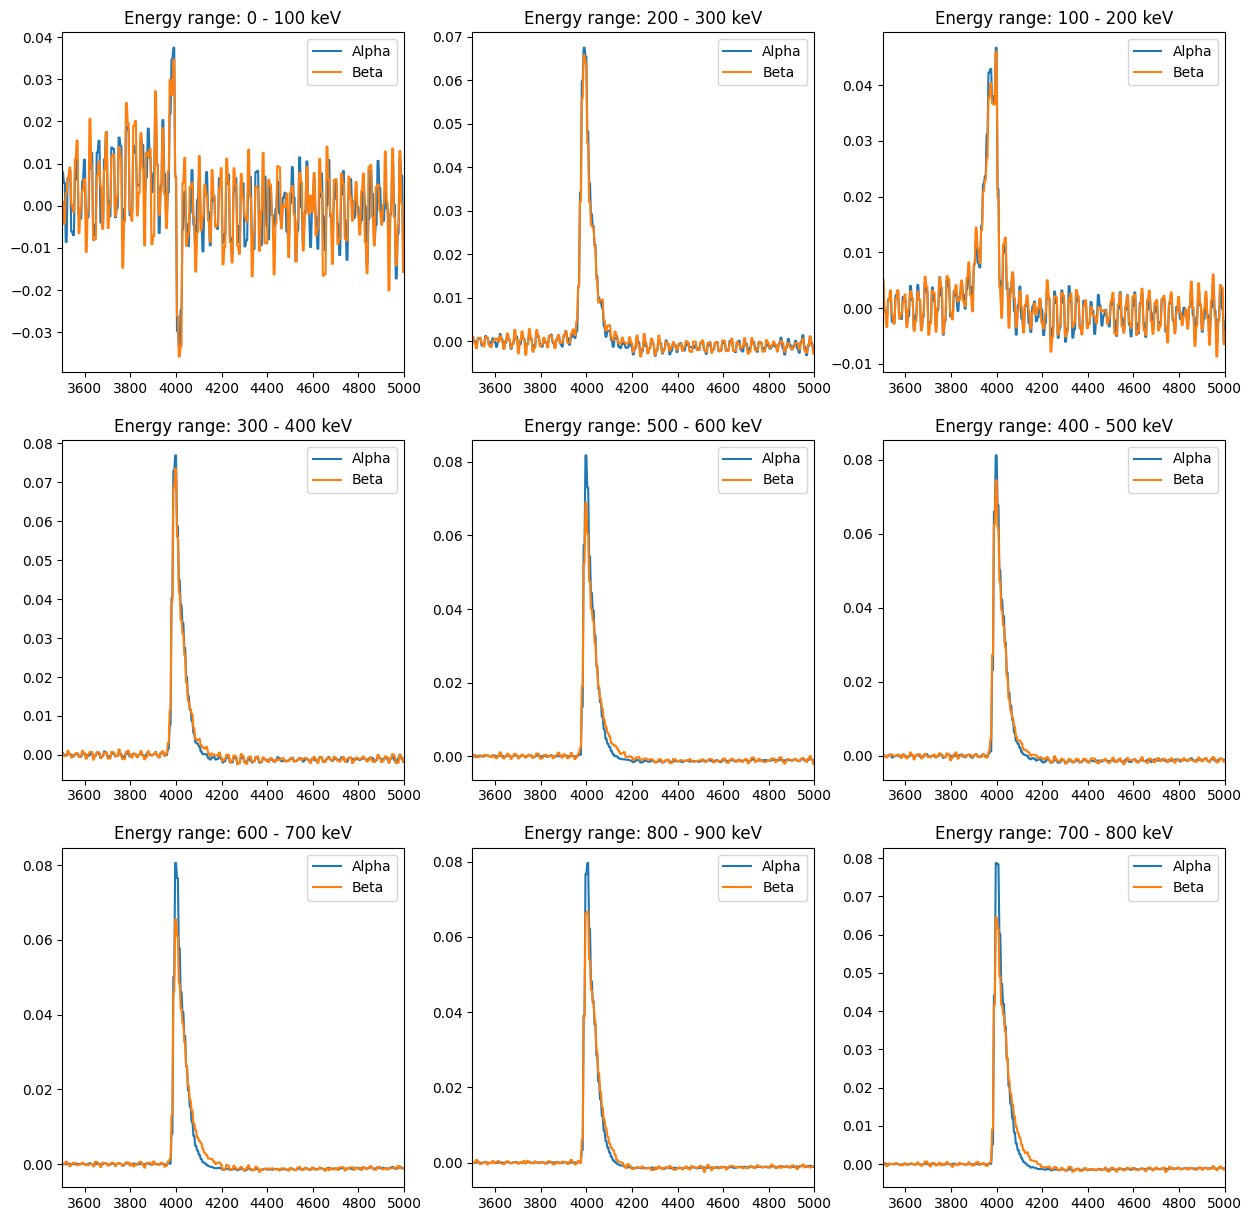

In [80]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(9):
    j = m.floor(i/3)
    k = (3-i)%3
    ax[j][k].plot(timeline, a_i_over_e_avg[i], label="Alpha")
    ax[j][k].plot(timeline, b_i_over_e_avg[i], label="Beta")
    ax[j][k].legend()
    ax[j][k].set_xlim(3500, 5000)
    ax[j][k].set_title(f"Energy range: {i*100} - {(i+1)*100} keV")

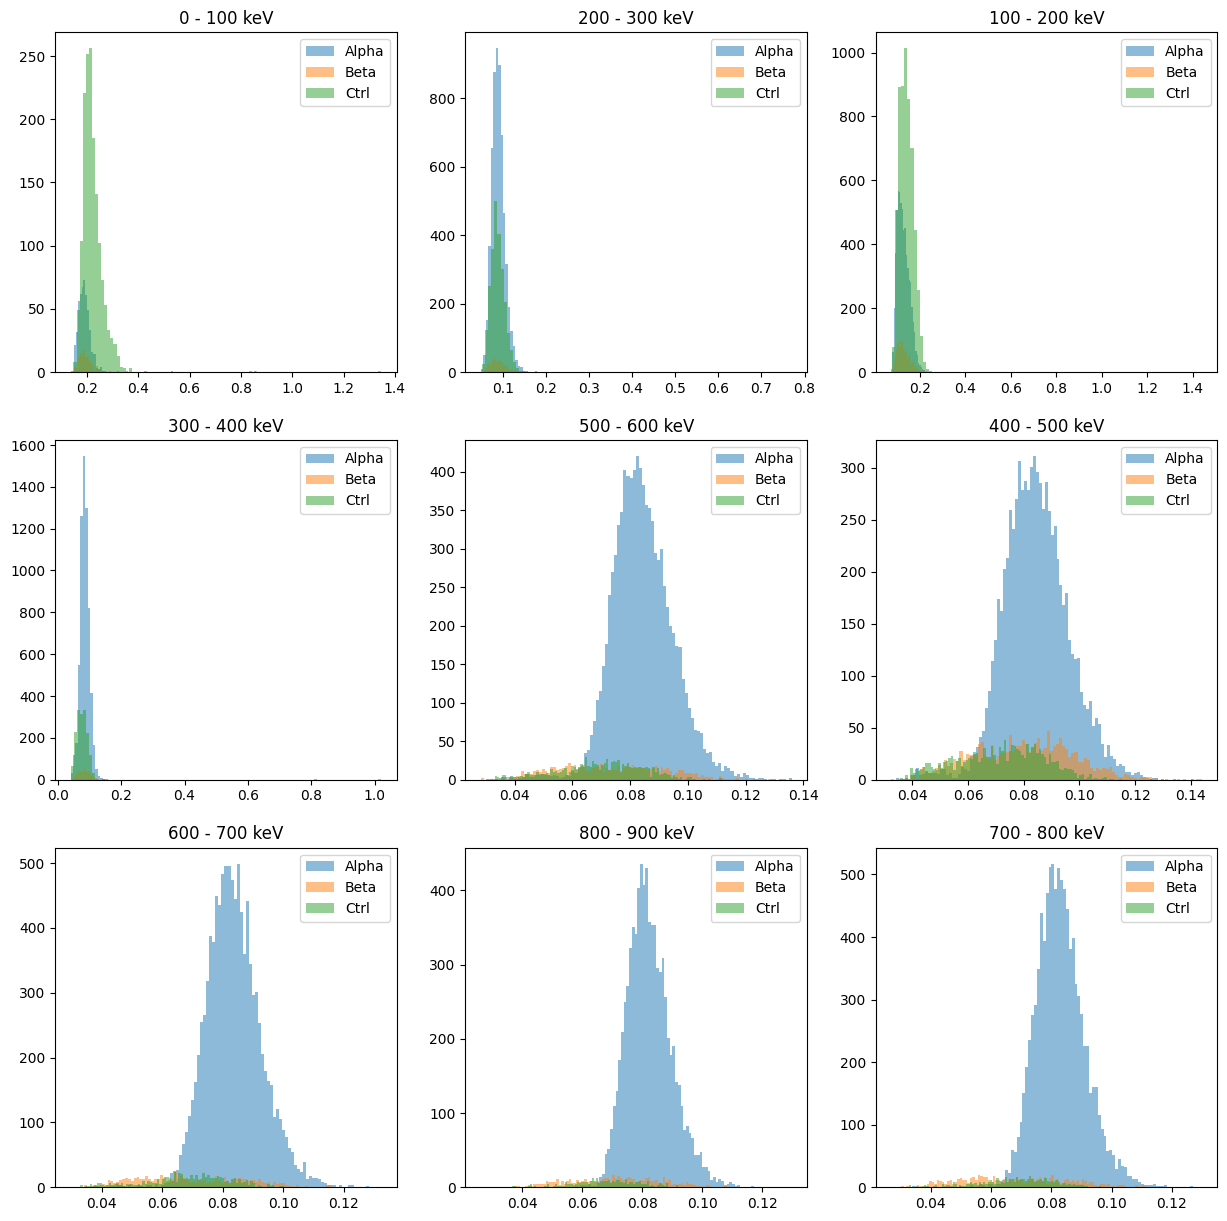

In [77]:
fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i, slice in enumerate(a_i_over_e):
    a_maxes = np.max(slice, axis=1)
    b_maxes = np.max(b_i_over_e[i], axis=1)
    c_maxes = np.max(c_i_over_e[i], axis=1)

    j = m.floor(i/3)
    k = (3-i)%3

    axs[j][k].hist(a_maxes, bins=100, alpha=0.5, label="Alpha")
    axs[j][k].hist(b_maxes, bins=100, alpha=0.5, label="Beta")
    axs[j][k].hist(c_maxes, bins=100, alpha=0.5, label="Ctrl")
    axs[j][k].set_title(f"{i*100} - {(i+1)*100} keV")
    axs[j][k].legend()
plt.show()
    

In [ ]:
'''a_maxes = [item[0] for item in a_data]
a_wfs = [item[1] for item in a_data]
norm_a_wfs = np.array([wf/np.max(wf) for wf in a_wfs])

b_maxes = [item[0] for item in b_data]
b_wfs = [item[1] for item in b_data]
norm_b_wfs = np.array([wf/np.max(wf) for wf in b_wfs])

ctrl_maxes = [item[0] for item in ctrl_data]
ctrl_wfs = [item[1] for item in ctrl_data] 
norm_ctrl_wfs = np.array([wf/np.max(wf) for wf in ctrl_wfs])

print("a: ", np.shape(norm_a_wfs))
print("b: ", np.shape(norm_b_wfs))

plt.hist(a_maxes, bins=bins)
plt.hist(b_maxes, bins=bins)'''

In [20]:
'''a_class_wfs_roi1 = [item[1] for item in a_classed[0]]
b_class_wfs_roi1 = [item[1] for item in b_classed[0]]

c_class_wfs_roi1 = [item[1] for item in ctrl_classed[0]]

a_maxi_roi1 = [item[0] for item in a_classed[0]]
b_maxi_roi1 = [item[0] for item in b_classed[0]]
c_maxi_roi1 = [item[0] for item in ctrl_classed[0]]

super_a_wfs_roi1 = np.average(a_class_wfs_roi1/np.max(a_class_wfs_roi1, axis=1)[:,None], axis=0)
super_b_wfs_roi1 = np.average(b_class_wfs_roi1/np.max(b_class_wfs_roi1, axis=1)[:,None], axis=0)
super_c_wfs_roi1 = np.average(c_class_wfs_roi1/np.max(c_class_wfs_roi1, axis=1)[:,None], axis=0)'''

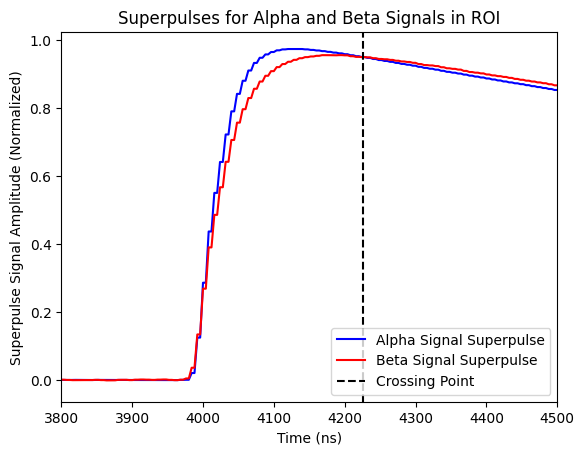

In [21]:



plt.plot(timeline, super_a_wfs_roi1, color='blue', label='Alpha Signal Superpulse')
plt.plot(timeline, super_b_wfs_roi1, color='red', label='Beta Signal Superpulse')
plt.ylabel('Superpulse Signal Amplitude (Normalized)')
plt.xlim(3800,4500)
plt.axvline(4226, color='black', linestyle='--', label='Crossing Point')
#plt.tight_layout()
plt.xlabel('Time (ns)')
plt.title('Superpulses for Alpha and Beta Signals in ROI')
plt.legend()

In [22]:
def get_derivative_single(wf, window=(0,5000)):
    wf = wf[window[0]:window[1]]
    return np.gradient(wf)

def get_derivatives(wfs, window=(0,5000)):
    wfs = wfs[:,window[0]:window[1]]
    return np.gradient(wfs, axis=1)


In [26]:
range1 = (int(3800/4),int(4500/4))
timeline_cut = timeline[range1[0]:range1[1]]

In [27]:
a_derivatives = get_derivatives(norm_a_wfs, window=range1)
b_derivatives = get_derivatives(norm_b_wfs, window=range1)
c_derivatives = get_derivatives(norm_ctrl_wfs, window=range1)

da_maxes = np.max(a_derivatives, axis=1)
db_maxes = np.max(b_derivatives, axis=1)
dc_maxes = np.max(c_derivatives, axis=1)
